# Finding aperture photometry from the data

This file will demonstrate the procedure to extract aperture photometry from the data. What we will do is simply sum-up all flux inside the aperture. We will use `photutils` package to do this.

We will compute "growth function" (see, below) to define the size of the aperture.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Wedge
from astropy.stats import mad_std
from tqdm import tqdm
import utils

Loading and visualising the data, 

Text(0.5, 1.0, 'Example data at an arbitrary integration')

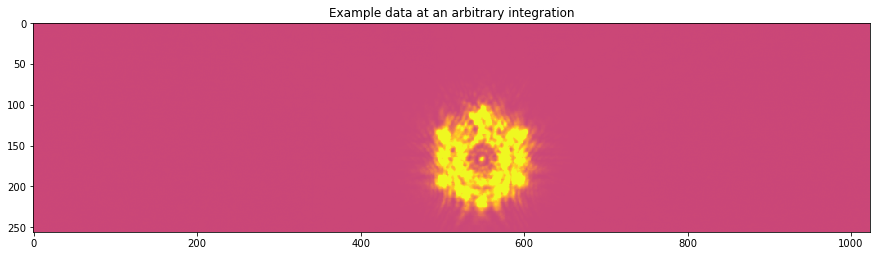

In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_NRCSW'
pout = p1 + '/SW/Outputs/Tests'

corrected_data = np.load(pin + '/Corrected_data_seg001.npy')
corrected_errs = np.load(pin + '/Corrected_errors_seg001.npy')
mask_bcr = np.load(pin + '/Mask_bcr_seg001.npy')
times_bjd = np.load(pin + '/Times_bjd_seg001.npy')

nint = np.random.randint(0, corrected_data.shape[0])

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], cmap='plasma', interpolation='none')
im.set_clim([-50,50])
plt.title('Example data at an arbitrary integration')

Before finding the flux inside the aperture, let's first find the centroids of PSF using center-of-flux method. We will basically use the formulae as below:

$$c_x = \frac{\sum_{x=0}^{n_x} (x\sum_{y=0}^{n_y} F_{x,y})}{\sum_{x=0}^{n_x}\sum_{y=0}^{n_y} F_{x,y}}$$

and,

$$c_y = \frac{\sum_{y=0}^{n_y} (y\sum_{x=0}^{n_x} F_{x,y})}{\sum_{x=0}^{n_x}\sum_{y=0}^{n_y} F_{x,y}}$$

These functions are already implemented in a function in `utils.py`. We will use that function directly below.

Center when using the whole image: (548.7023, 166.3687)


Text(0.5, 1.0, 'Example data at an arbitrary integration with centroids (as white circle)')

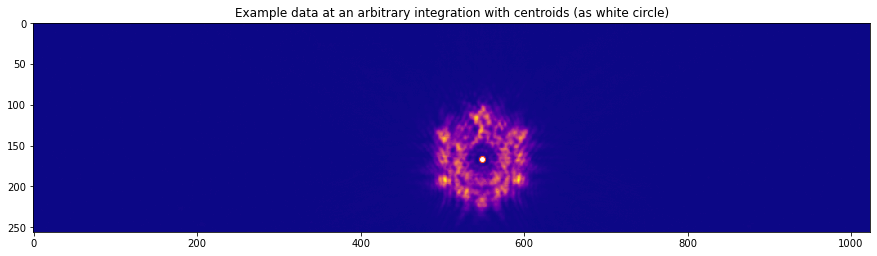

In [3]:
cen1, cen2 = utils.find_center(corrected_data[nint, :, :], rmin=75, rmax=255, cmin=458, cmax=638)

print('Center when using the whole image: ({:.4f}, {:.4f})'.format(cen2, cen1))

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], cmap='plasma', interpolation='none')
plt.errorbar(cen2, cen1, fmt='o', c='orangered', mfc='white')
plt.title('Example data at an arbitrary integration with centroids (as white circle)')

We will now compute what is called growth function to estimate the size of the aperture. The idea is to compute aperture flux as a function of aperture radius. We will see that the flux inside the aperture will start flattening out at some radius --- we will use that radius as the radius of our aperture.

100%|██████████| 120/120 [00:00<00:00, 176.65it/s]


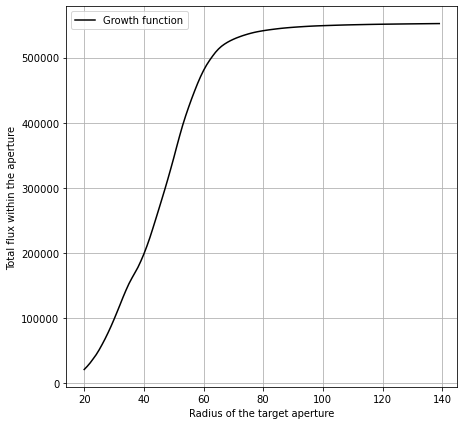

In [4]:
rads54 = np.arange(20,140,1)
apr_rad56 = np.zeros(len(rads54))

for i in tqdm(range(len(rads54))):
    apr_rad56[i], _, _ = utils.aperture_photometry(image=corrected_data[nint,:,:], err=corrected_errs[nint,:,:],\
                                                   cen_r=cen1, cen_c=cen2, rad=rads54[i], sky_rad1=150, sky_rad2=350)

plt.figure(figsize=(7,7))
plt.plot(rads54, apr_rad56, label='Growth function', c='black')
#plt.axvline(x=20, label='Radius of 20 pixels', c='cornflowerblue')
#plt.axvline(x=40, label='Radius of 40 pixels', c='orangered')
plt.xlabel('Radius of the target aperture')
plt.ylabel('Total flux within the aperture')
plt.legend(loc='best')
plt.grid()

Nice! The flux almost flattens out after ~80 pixels. We will use aperture size of 85 pixels in our subsequent analysis.

Now, it's finally time to compute the timeseries of the aperture flux, that is, aperture photometry. We basically have two methods to compute aperture photoemetry: either use annulus background subtraction or perform aperture photometry without annulus background subtraction. We can choose the latter option because we already performed background subtraction in Stage 1 analysis using ROEBA algorithm. So, it is indeed possible that doing another background subtraction won't improve the things much. We will experiment with both cases below and see which one performs better in terms of MAD.

### Method 1: With annulus background subtraction

100%|██████████| 119/119 [00:00<00:00, 178.39it/s]


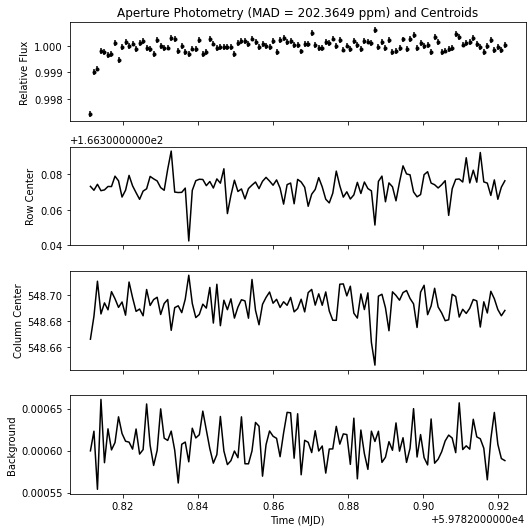

In [5]:
fl_wBKG, fle_wBKG, BKG = np.zeros(len(times_bjd)), np.zeros(len(times_bjd)), np.zeros(len(times_bjd))
cx_wBKG, cy_wBKG = np.zeros(len(times_bjd)), np.zeros(len(times_bjd))

for i in tqdm(range(len(times_bjd))):
    # First finding the center
    c1, c2 = utils.find_center(corrected_data[i, :, :], rmin=75, rmax=255, cmin=458, cmax=638)
    cx_wBKG[i], cy_wBKG[i] = c1, c2
    fl_wBKG[i], fle_wBKG[i], BKG[i] = utils.aperture_photometry(image=corrected_data[i,:,:], \
                                                                err=corrected_errs[i,:,:],\
                                                                cen_r=cen1, cen_c=cen2, rad=85.,\
                                                                sky_rad1=150, sky_rad2=350)

# And plotting the results
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7.5, 7.5), sharex=True)

axs[0].errorbar(times_bjd, fl_wBKG/np.median(fl_wBKG), yerr=fle_wBKG/np.median(fl_wBKG), fmt='.', c='k')
axs[0].set_ylabel('Relative Flux')

axs[1].errorbar(times_bjd, cx_wBKG, c='k')
axs[1].set_ylabel('Row Center')

axs[2].errorbar(times_bjd, cy_wBKG, c='k')
axs[2].set_ylabel('Column Center')

axs[3].errorbar(times_bjd, BKG/np.median(fl_wBKG), c='k')
axs[3].set_ylabel('Background')

axs[3].set_xlabel('Time (MJD)')

axs[0].set_title('Aperture Photometry (MAD = {:.4f} ppm) and Centroids'.format(mad_std(fl_wBKG/np.median(fl_wBKG)) * 1e6))

plt.tight_layout()

### Method 2: without annulus background subtraction

100%|██████████| 119/119 [00:00<00:00, 365.41it/s]


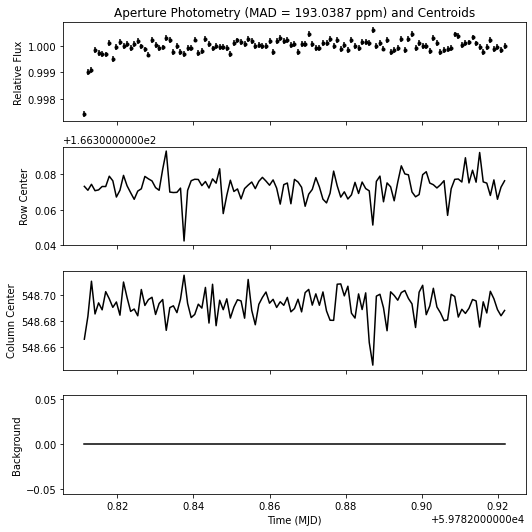

In [6]:
fl_woBKG, fle_woBKG, BKG1 = np.zeros(len(times_bjd)), np.zeros(len(times_bjd)), np.zeros(len(times_bjd))
cx_woBKG, cy_woBKG = np.zeros(len(times_bjd)), np.zeros(len(times_bjd))

for i in tqdm(range(len(times_bjd))):
    # First finding the center
    c1, c2 = utils.find_center(corrected_data[i, :, :], rmin=75, rmax=255, cmin=458, cmax=638)
    cx_woBKG[i], cy_woBKG[i] = c1, c2
    fl_woBKG[i], fle_woBKG[i], BKG1[i] = utils.aperture_photometry(image=corrected_data[i,:,:], \
                                                                err=corrected_errs[i,:,:],\
                                                                cen_r=cen1, cen_c=cen2, rad=85.,\
                                                                sky_rad1=None, sky_rad2=None)

# And plotting the results
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7.5, 7.5), sharex=True)

axs[0].errorbar(times_bjd, fl_woBKG/np.median(fl_woBKG), yerr=fle_woBKG/np.median(fl_woBKG), fmt='.', c='k')
axs[0].set_ylabel('Relative Flux')

axs[1].errorbar(times_bjd, cx_woBKG, c='k')
axs[1].set_ylabel('Row Center')

axs[2].errorbar(times_bjd, cy_woBKG, c='k')
axs[2].set_ylabel('Column Center')

axs[3].errorbar(times_bjd, BKG1/np.median(fl_woBKG), c='k')
axs[3].set_ylabel('Background')

axs[3].set_xlabel('Time (MJD)')

axs[0].set_title('Aperture Photometry (MAD = {:.4f} ppm) and Centroids'.format(mad_std(fl_woBKG/np.median(fl_woBKG)) * 1e6))

plt.tight_layout()

Looks like the aperture photometry without annulus background subtraction produces photometry with lower scatter. So, in the end we will not perform annulus background subtraction to aperture photometry.